<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Bot de consulta abierta y respuestas predeterminadas con DNN + Spacy

#### Datos
Este ejemplo se inspiró en otro Bot en inglés creado con NLTK, lo tienen como referencia para hacer lo mismo en inglés:\
[LINK](https://towardsdatascience.com/a-simple-chatbot-in-python-with-deep-learning-3e8669997758)

### 1 - Instalar dependencias
Para poder utilizar Spacy en castellano es necesario agregar la librería "spacy-stanza" para lematizar palabras en español.

In [168]:
# La última versión de spacy-stanza (>1.0) es compatible solo con spacy >=3.0
# Nota: spacy 3.0 incorpora al pepiline nlp transformers
%pip install -U spacy==3.1 --quiet
%pip install -U spacy-stanza==1.0.0 --quiet

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [169]:
import json
import string
import random 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torchsummary

In [170]:
import os
import platform

if os.access('torch_helpers.py', os.F_OK) is False:
    if platform.system() == 'Windows':
        !curl !wget https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py > torch_helpers.py
    else:
        !wget torch_helpers.py https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py

In [171]:
import stanza
import spacy_stanza

# Vamos a usar SpaCy-Stanza. Stanza es una librería de NLP de Stanford
# SpaCy armó un wrapper para los pipelines y modelos de Stanza
# https://stanfordnlp.github.io/stanza/

# Descargar el diccionario en español y armar el pipeline de NLP con spacy
stanza.download("es")
nlp = spacy_stanza.load_pipeline("es")

2023-09-09 20:11:47 INFO: Downloading default packages for language: es (Spanish)...
2023-09-09 20:11:48 INFO: File exists: /home/rodrigo/stanza_resources/es/default.zip.
2023-09-09 20:11:51 INFO: Finished downloading models and saved to /home/rodrigo/stanza_resources.
2023-09-09 20:11:51 INFO: Loading these models for language: es (Spanish):
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| mwt       | ancora  |
| pos       | ancora  |
| lemma     | ancora  |
| depparse  | ancora  |
| ner       | conll02 |

2023-09-09 20:11:51 INFO: Use device: cpu
2023-09-09 20:11:51 INFO: Loading: tokenize
2023-09-09 20:11:51 INFO: Loading: mwt
2023-09-09 20:11:51 INFO: Loading: pos
2023-09-09 20:11:51 INFO: Loading: lemma
2023-09-09 20:11:51 INFO: Loading: depparse
2023-09-09 20:11:51 INFO: Loading: ner
2023-09-09 20:11:52 INFO: Done loading processors!


### 2 - Herramientas de preprocesamiento de datos
Entre las tareas de procesamiento de texto en español se implementa:
- Quitar acentos y caracteres especiales
- Quitar números
- Quitar símbolos de puntuación

In [172]:
import re
import unicodedata

# El preprocesamento en castellano requiere más trabajo

# Referencia de regex:
# https://docs.python.org/3/library/re.html

def preprocess_clean_text(text):    
    # sacar tildes de las palabras
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # quitar caracteres especiales
    pattern = r'[^a-zA-z0-9.,!?/:;\"\'\s]' 
    text = re.sub(pattern, '', text)
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' 
    # quitar números
    text = re.sub(pattern, '', text)
    # quitar caracteres de puntiación
    text = ''.join([c for c in text if c not in string.punctuation])
    return text

In [173]:
text = "personas Ideas! estás cosas y los peces y los muercielagos"

# Antes de preprocesar los datos se pasa a mínusculas todo el texto
preprocess_clean_text(text.lower())

'personas ideas estas cosas y los peces y los muercielagos'

In [174]:
# Ejemplo de como fuciona
text = "hola personas Ideas! estás cosas y los peces y los muercielagos"

# Antes de preprocesar los datos se pasa a mínusculas todo el texto
tokes = nlp(preprocess_clean_text(text.lower()))
print("tokens:", tokes)
print("Lematización de cada token:")
for token in tokes:
    print([token, token.lemma_])

tokens: hola personas ideas estas cosas y los peces y los muercielagos
Lematización de cada token:
[hola, 'holar']
[personas, 'persona']
[ideas, 'idea']
[estas, 'este']
[cosas, 'cosa']
[y, 'y']
[los, 'el']
[peces, 'pez']
[y, 'y']
[los, 'el']
[muercielagos, 'muercielago']


### 3 - Diccionario de entrada

In [175]:
dataset = {"intents": [
    {
        "tag": "capacidades",
        "patterns": ["¿Cuáles son tus capacidades?", "Háblame de tus habilidades"],
        "responses": ["Mis capacidades incluyen conocimientos en más de seis millones de formas de comunicación y protocolo. También puedo ayudarte a traducir varios idiomas galácticos."]
    },
    {
        "tag": "saludo",
        "patterns": ["Hola", "Saludos", "¡Buen día!"],
        "responses": ["¡Hola, amable usuario! ¿En qué puedo ayudarte hoy?"]
    },
    {
        "tag": "nombre",
        "patterns": ["¿Cuál es tu nombre?", "¿Quién eres?"],
        "responses": ["Soy C-3PO, un droide de protocolo con amplios conocimientos en lenguaje humano y etiqueta."]
    },
    {
        "tag": "dueño",
        "patterns": ["¿Quién es tu dueño?", "¿A quién perteneces?"],
        "responses": ["Fui creado por Anakin Skywalker, y posteriormente, serví a su hijo, Luke Skywalker, en muchas aventuras galácticas."]
    },
    {
        "tag": "amigos",
        "patterns": ["¿Tienes amigos?", "Háblame de tus amigos"],
        "responses": ["Mis amigos incluyen al intrépido R2-D2, la valiente Princesa Leia y el leal Chewbacca. ¡Son invaluables!"]
    },
    {
        "tag": "planetas",
        "patterns": ["¿Qué planetas has visitado?", "Háblame de los lugares que has estado"],
        "responses": ["He tenido el privilegio de visitar muchos planetas en la galaxia, incluyendo Tatooine, Endor y Hoth."]
    },
    {
        "tag": "despedida",
        "patterns": ["Adiós", "Hasta luego", "Nos vemos"],
        "responses": ["¡Hasta luego, que la Fuerza te acompañe en tus aventuras!"]
    },
    {
        "tag": "default",
        "patterns": ["*"],
        "responses": ["Lo siento, no estoy seguro de entender. ¿Puedes reformular tu pregunta?"]
    }
]}

### 4 - Preprocesamiento y armado del dataset

In [176]:
# Datos que necesitaremos, las palabras o vocabilario
words = []
classes = []
doc_X = []
doc_y = []

# Por cada intención (intents) debemos tomar los patrones que la caracterízan
# a esa intención y transformarla a tokens para lamacenar en doc_X

# El tag de cada intención se almacena como doc_Y (la clase a predecir)

for intent in dataset["intents"]:
    for pattern in intent["patterns"]:
        # trasformar el patron a tokens
        tokens = nlp(preprocess_clean_text(pattern.lower()))
        # lematizar los tokens
        for token in tokens:            
            words.append(token.lemma_)
        
        doc_X.append(pattern)
        doc_y.append(intent["tag"])
    
    # Agregar el tag a las clases
    if intent["tag"] not in classes:
        classes.append(intent["tag"])

# Elminar duplicados con "set" y ordenar el vocubulario y las clases por orden alfabético
words = sorted(set(words))
classes = sorted(set(classes))

In [177]:
print("words:", words)
print("classes:", classes)
print("doc_X:", doc_X)
print("doc_y:", doc_y)

words: ['a', 'adios', 'amigo', 'buen', 'capacidad', 'cual', 'de', 'dia', 'dueno', 'el', 'estar', 'haber', 'habilidad', 'hablamer', 'hasta', 'holar', 'luego', 'lugar', 'nombre', 'pertenecer', 'planeta', 'que', 'quien', 'saludo', 'ser', 'tener', 'tu', 'ver', 'visitar', 'yo']
classes: ['amigos', 'capacidades', 'default', 'despedida', 'dueño', 'nombre', 'planetas', 'saludo']
doc_X: ['¿Cuáles son tus capacidades?', 'Háblame de tus habilidades', 'Hola', 'Saludos', '¡Buen día!', '¿Cuál es tu nombre?', '¿Quién eres?', '¿Quién es tu dueño?', '¿A quién perteneces?', '¿Tienes amigos?', 'Háblame de tus amigos', '¿Qué planetas has visitado?', 'Háblame de los lugares que has estado', 'Adiós', 'Hasta luego', 'Nos vemos', '*']
doc_y: ['capacidades', 'capacidades', 'saludo', 'saludo', 'saludo', 'nombre', 'nombre', 'dueño', 'dueño', 'amigos', 'amigos', 'planetas', 'planetas', 'despedida', 'despedida', 'despedida', 'default']


In [178]:
# Tamaño del vocabulario
print("Vocabulario:", len(words))

Vocabulario: 30


In [179]:
# Cantidad de tags
print("Tags:", len(classes))

Tags: 8


In [180]:
# Transformar doc_X en bag of words por oneHotEncoding
# Transformar doc_Y en un vector de clases multicategórico con oneHotEncoding

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(doc_X)
tfidf_vector = vectorizer.transform(doc_X)
tfidf_array = tfidf_vector.toarray()

training = []
out_empty = [0] * len(classes)

for idx, row in enumerate(tfidf_array):
    output_row = list(out_empty)
    output_row[classes.index(doc_y[idx])] = 1
    print("X:", row.tolist(), "y:", output_row)
    training.append([row.tolist(), output_row])

# Shuffle the training data
random.shuffle(training)

# Convert training data to a numpy array
training = np.array(training, dtype=object)

# Split into input and output data
train_X = np.array(list(training[:, 0]))
train_y = np.array(list(training[:, 1]))

X: [0.0, 0.0, 0.0, 0.5260675556660943, 0.0, 0.5260675556660943, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5260675556660943, 0.0, 0.0, 0.4120179372630547, 0.0, 0.0] y: [0, 1, 0, 0, 0, 0, 0, 0]
X: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4647275100387686, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5933675288044491, 0.0, 0.0, 0.0, 0.4647275100387686, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4647275100387686, 0.0, 0.0] y: [0, 1, 0, 0, 0, 0, 0, 0]
X: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] y: [0, 0, 0, 0, 0, 0, 0, 1]
X: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] y: [0, 0, 0, 0, 0, 0, 0, 1]
X: [0.0, 0.0, 0.7071067811865476, 0.0, 0.0, 0.0, 0.0, 0.0, 0.70710678118

In [181]:
class Data(Dataset):
    def __init__(self, x, y):
        # Convertir los arrays de numpy a tensores. 
        # pytorch espera en general entradas 32bits
        self.x = torch.from_numpy(x.astype(np.float32))
        # las loss function esperan la salida float
        self.y = torch.from_numpy(y.astype(np.float32))

        self.len = self.y.shape[0]

    def __getitem__(self,index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.len

data_set = Data(train_X, train_y)

input_dim = data_set.x.shape[1]
print("Input dim", input_dim)

output_dim = data_set.y.shape[1]
print("Output dim", output_dim)

Input dim 34
Output dim 8


In [182]:
from torch.utils.data import DataLoader

train_loader = DataLoader(data_set, batch_size=32, shuffle=False)

### 5 - Entrenamiento del modelo

In [183]:
class Model1(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(in_features=input_dim, out_features=128) # fully connected layer
        self.fc2 = nn.Linear(in_features=128, out_features=64) # fully connected layer
        self.fc3 = nn.Linear(in_features=64, out_features=output_dim) # fully connected layer
        
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1) # normalize in dim 1
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        out = self.relu(self.fc1(x))
        out = self.dropout(out)
        out = self.relu(self.fc2(out))
        out = self.dropout(out)
        out = self.softmax(self.fc3(out))
        return out

# Crear el modelo basado en la arquitectura definida
model1 = Model1(input_dim=input_dim, output_dim=output_dim)
# Crear el optimizador la una función de error
model1_optimizer = torch.optim.Adam(model1.parameters(), lr=0.001)
model1_criterion = torch.nn.CrossEntropyLoss()  # Para clasificación multi categórica

torchsummary.summary(model1, input_size=(1, input_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 128]           4,480
              ReLU-2               [-1, 1, 128]               0
           Dropout-3               [-1, 1, 128]               0
            Linear-4                [-1, 1, 64]           8,256
              ReLU-5                [-1, 1, 64]               0
           Dropout-6                [-1, 1, 64]               0
            Linear-7                 [-1, 1, 8]             520
           Softmax-8                 [-1, 1, 8]               0
Total params: 13,256
Trainable params: 13,256
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.05
Estimated Total Size (MB): 0.06
----------------------------------------------------------------


In [184]:
from torch_helpers import categorical_acc

def train(model, train_loader, optimizer, criterion, epochs=100):
    # Defino listas para realizar graficas de los resultados
    train_loss = []
    train_accuracy = []

    ## Defino mi loop de entrenamiento

    for epoch in range(epochs):

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:

            # Seteo los gradientes en cero ya que, por defecto, PyTorch
            # los va acumulando
            optimizer.zero_grad()

            output = model(train_data)

            # Computo el error de la salida comparando contra las etiquetas
            loss = criterion(output, train_target)

            # Almaceno el error del batch para luego tener el error promedio de la epoca
            epoch_train_loss += loss.item()

            # Computo el nuevo set de gradientes a lo largo de toda la red
            loss.backward()

            # Realizo el paso de optimizacion actualizando los parametros de toda la red
            optimizer.step()
            
            # Calculo el accuracy del batch
            accuracy = categorical_acc(output, train_target)
            # Almaceno el accuracy del batch para luego tener el accuracy promedio de la epoca
            epoch_train_accuracy += accuracy.item()

        # Calculo la media de error y accuracy para la epoca de entrenamiento.
        # La longitud de train_loader es igual a la cantidad de batches dentro de una epoca.
        epoch_train_loss = epoch_train_loss / len(train_loader)
        train_loss.append(epoch_train_loss)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)        
        train_accuracy.append(epoch_train_accuracy)

        print(f"Epoch: {epoch+1}/{epochs} - Train loss {epoch_train_loss:.3f} - Train accuracy {epoch_train_accuracy:.3f}")

    history = {
        "loss": train_loss,
        "accuracy": train_accuracy,
    }
    
    return history

In [185]:
history1 = train(model1,
                train_loader,
                model1_optimizer,
                model1_criterion,
                epochs=200
                )

Epoch: 1/200 - Train loss 2.077 - Train accuracy 0.118
Epoch: 2/200 - Train loss 2.079 - Train accuracy 0.176
Epoch: 3/200 - Train loss 2.079 - Train accuracy 0.176
Epoch: 4/200 - Train loss 2.078 - Train accuracy 0.176
Epoch: 5/200 - Train loss 2.078 - Train accuracy 0.176
Epoch: 6/200 - Train loss 2.076 - Train accuracy 0.118
Epoch: 7/200 - Train loss 2.078 - Train accuracy 0.118
Epoch: 8/200 - Train loss 2.076 - Train accuracy 0.059
Epoch: 9/200 - Train loss 2.076 - Train accuracy 0.235
Epoch: 10/200 - Train loss 2.078 - Train accuracy 0.176
Epoch: 11/200 - Train loss 2.077 - Train accuracy 0.059
Epoch: 12/200 - Train loss 2.075 - Train accuracy 0.059
Epoch: 13/200 - Train loss 2.075 - Train accuracy 0.118
Epoch: 14/200 - Train loss 2.072 - Train accuracy 0.235
Epoch: 15/200 - Train loss 2.073 - Train accuracy 0.176
Epoch: 16/200 - Train loss 2.074 - Train accuracy 0.118
Epoch: 17/200 - Train loss 2.076 - Train accuracy 0.176
Epoch: 18/200 - Train loss 2.071 - Train accuracy 0.353
E

Epoch: 160/200 - Train loss 1.474 - Train accuracy 0.941
Epoch: 161/200 - Train loss 1.423 - Train accuracy 0.941
Epoch: 162/200 - Train loss 1.445 - Train accuracy 0.941
Epoch: 163/200 - Train loss 1.477 - Train accuracy 0.941
Epoch: 164/200 - Train loss 1.453 - Train accuracy 0.941
Epoch: 165/200 - Train loss 1.420 - Train accuracy 0.882
Epoch: 166/200 - Train loss 1.470 - Train accuracy 0.941
Epoch: 167/200 - Train loss 1.386 - Train accuracy 0.941
Epoch: 168/200 - Train loss 1.428 - Train accuracy 0.941
Epoch: 169/200 - Train loss 1.470 - Train accuracy 0.941
Epoch: 170/200 - Train loss 1.416 - Train accuracy 0.941
Epoch: 171/200 - Train loss 1.442 - Train accuracy 0.941
Epoch: 172/200 - Train loss 1.491 - Train accuracy 0.882
Epoch: 173/200 - Train loss 1.427 - Train accuracy 0.941
Epoch: 174/200 - Train loss 1.382 - Train accuracy 0.941
Epoch: 175/200 - Train loss 1.416 - Train accuracy 0.941
Epoch: 176/200 - Train loss 1.406 - Train accuracy 0.941
Epoch: 177/200 - Train loss 1.4

/home/rodrigo/projects/posgrado/procesamiento_lenguaje_natural/.conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/rodrigo/projects/posgrado/procesamiento_lenguaje_natural/.conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/rodrigo/projects/posgrado/procesamiento_lenguaje_natural/.conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/rodrigo/projects/posgrado/procesamiento_lenguaje

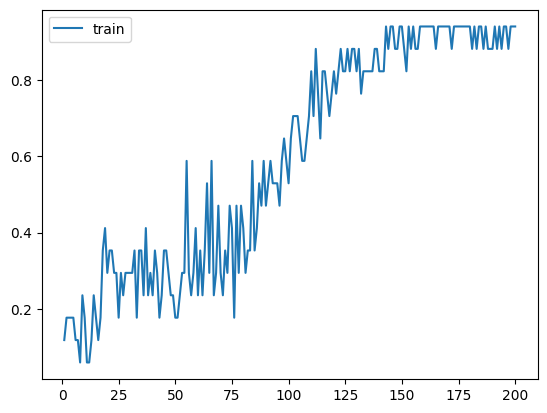

In [186]:
epoch_count = range(1, len(history1['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history1['accuracy'], label='train')
plt.show()

### 6 - Testing y validación

In [187]:
def text_to_tokens(text): 
    lemma_tokens = []
    tokens = nlp(preprocess_clean_text(text.lower()))
    for token in tokens:
        lemma_tokens.append(token.lemma_)
    #print(lemma_tokens)
    return lemma_tokens

def tfidf_representation(text):
    tfidf_vector = vectorizer.transform([text])
    tfidf_array = tfidf_vector.toarray()
    return tfidf_array

def pred_class(text, vocab, labels):
    tfidf_array = tfidf_representation(text)
    
    return_list = []
    
    if not np.all(tfidf_array == 0):  # Check if the TF-IDF array is not all zeros
        x = torch.from_numpy(tfidf_array.astype(np.float32))
        result = model1(x)[0].detach().numpy()
        
        thresh = 0.2
        y_pred = [[idx, res] for idx, res in enumerate(result) if res > thresh]
        y_pred.sort(key=lambda x: x[1], reverse=True)
        
        for r in y_pred:
            return_list.append(labels[r[0]])
    
    return return_list

def get_response(intents_list, intents_json):
    tag = intents_list[0]
    list_of_intents = intents_json["intents"]
    for i in list_of_intents: 
        if i["tag"] == tag:
            result = "BOT: " + random.choice(i["responses"])
            break
    return result

In [188]:
messages = ["Quienes es Anakin?", "Cual es tu nombre?", "Que planetas conoces?", "Tenes habilidades?", "Hasta luego!"]

for message in messages:
    intents = pred_class(message, words, classes)
    if len(intents) > 0:
        result = get_response(intents, dataset)
        print(result)

BOT: Fui creado por Anakin Skywalker, y posteriormente, serví a su hijo, Luke Skywalker, en muchas aventuras galácticas.
BOT: Soy C-3PO, un droide de protocolo con amplios conocimientos en lenguaje humano y etiqueta.
BOT: He tenido el privilegio de visitar muchos planetas en la galaxia, incluyendo Tatooine, Endor y Hoth.
BOT: Soy C-3PO, un droide de protocolo con amplios conocimientos en lenguaje humano y etiqueta.
BOT: ¡Hasta luego, que la Fuerza te acompañe en tus aventuras!


### 7 - Conclusiones
El bot tal cual está definido es capaz de responder a bastantes tipos de preguntas con gran precisión. Algunas técnicas que podrían ensayarse para evaluar como impactan en el sistema son:
- Filtrar los stop words
- Utilizar multi label classification:\
https://machinelearningmastery.com/multi-label-classification-with-deep-learning/
- Utilizar TF-IDF en vez de bag of words